In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LinearRegression
from math import sqrt, log
from sklearn import linear_model

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [3]:
sales = pd.read_csv("~/Desktop/ML_Washington/WashingtonML/Regression/Week2/kc_house_data.csv", dtype = dtype_dict)

In [181]:
testing = pd.read_csv("~/Desktop/ML_Washington/WashingtonML/Regression/Week5/kc_house_test_data.csv", dtype = dtype_dict)
training = pd.read_csv("~/Desktop/ML_Washington/WashingtonML/Regression/Week5/kc_house_train_data.csv", dtype = dtype_dict)


In [5]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [6]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Normalize features
In the house dataset, features vary wildly in their relative magnitude: `sqft_living` is very large overall compared to `bedrooms`, for instance. As a result, weight for `sqft_living` would be much smaller than weight for `bedrooms`. This is problematic because "small" weights are dropped first as `l1_penalty` goes up. 

To give equal considerations for all features, we need to **normalize features** as discussed in the lectures: we divide each feature by its 2-norm so that the transformed feature has norm 1.

Let's see how we can do this normalization easily with Numpy: let us first consider a small matrix.

In [9]:
X = np.array([[3.,5.,8.],[4.,12.,15.]])
print (X)

[[ 3.  5.  8.]
 [ 4. 12. 15.]]


In [10]:
norms = np.linalg.norm(X, axis=0) # gives [norm(X[:,0]), norm(X[:,1]), norm(X[:,2])]
print (norms)

[ 5. 13. 17.]


In [12]:
print (X / norms) # gives [X[:,0]/norm(X[:,0]), X[:,1]/norm(X[:,1]), X[:,2]/norm(X[:,2])]

[[0.6        0.38461538 0.47058824]
 [0.8        0.92307692 0.88235294]]


Using the shorthand we just covered, write a short function called `normalize_features(feature_matrix)`, which normalizes columns of a given feature matrix. The function should return a pair `(normalized_features, norms)`, where the second item contains the norms of original features. As discussed in the lectures, we will use these norms to normalize the test data in the same way as we normalized the training data. 

In [13]:
def normalize_features(features):
    norms = np.linalg.norm(features, axis =0)
    normalized_features = features/norms
    return (normalized_features, norms)

To test the function, run the following:

In [15]:
features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print (features)
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print (norms)
# should print
# [5.  10.  15.]

[[0.6 0.6 0.6]
 [0.8 0.8 0.8]]
[ 5. 10. 15.]


# Implementing Coordinate Descent with normalized features

We seek to obtain a sparse set of weights by minimizing the LASSO cost function
```
SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|).
```
(By convention, we do not include `w[0]` in the L1 penalty term. We never want to push the intercept to zero.)

The absolute value sign makes the cost function non-differentiable, so simple gradient descent is not viable (you would need to implement a method called subgradient descent). Instead, we will use **coordinate descent**: at each iteration, we will fix all weights but weight `i` and find the value of weight `i` that minimizes the objective. That is, we look for
```
argmin_{w[i]} [ SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|) ]
```
where all weights other than `w[i]` are held to be constant. We will optimize one `w[i]` at a time, circling through the weights multiple times.  
  1. Pick a coordinate `i`
  2. Compute `w[i]` that minimizes the cost function `SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|)`
  3. Repeat Steps 1 and 2 for all coordinates, multiple times

For this notebook, we use **cyclical coordinate descent with normalized features**, where we cycle through coordinates 0 to (d-1) in order, and assume the features were normalized as discussed above. The formula for optimizing each coordinate is as follows:
```
       ┌ (ro[i] + lambda/2)     if ro[i] < -lambda/2
w[i] = ├ 0                      if -lambda/2 <= ro[i] <= lambda/2
       └ (ro[i] - lambda/2)     if ro[i] > lambda/2
```
where
```
ro[i] = SUM[ [feature_i]*(output - prediction + w[i]*[feature_i]) ].
```

Note that we do not regularize the weight of the constant feature (intercept) `w[0]`, so, for this weight, the update is simply:
```
w[0] = ro[i]
```

#### The reason we have " w[i]*[feature_i] " term in the ro[i] because of the prediction term which includes the ith feature but as per the coordiante descent we need to ignore the feature i to get the prediction. *****

In [17]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)

In [18]:
simple_feature_matrix, norms = normalize_features(simple_feature_matrix)

In [19]:
weights = np.array([1., 4., 1.])

In [20]:
prediction = predict_output(simple_feature_matrix, weights)

Compute the values of `ro[i]` for each feature in this simple model, using the formula given above, using the formula:
```
ro[i] = SUM[ [feature_i]*(output - prediction + w[i]*[feature_i]) ]
```

*Hint: You can get a Numpy vector for feature_i using:*
```
simple_feature_matrix[:,i]
```

In [21]:
len(simple_features)

2

In [30]:
ro_lst = []
for i in range(len(simple_features)+1):
    ro = sum(simple_feature_matrix[:,i] * (output - prediction + weights[i]*simple_feature_matrix[:,i]) )
    print(ro)
    ro_lst.append(ro)

79400300.01452321
87939470.82325152
80966698.66623905


In [31]:
ro_lst

[79400300.01452321, 87939470.82325152, 80966698.66623905]

***QUIZ QUESTION***

Recall that, whenever `ro[i]` falls between `-l1_penalty/2` and `l1_penalty/2`, the corresponding weight `w[i]` is sent to zero. Now suppose we were to take one step of coordinate descent on either feature 1 or feature 2. What range of values of `l1_penalty` **would not** set `w[1]` zero, but **would** set `w[2]` to zero, if we were to take a step in that coordinate? 

In [32]:
w_1 = ro_lst[1]

In [34]:
## ro[i] < -lambda/2  ## ro[i] > lambda/2
lambda_ = w_1 * 2
lambda_

175878941.64650303

In [35]:
the range is lambda_ < -175878941.64650303 and lambda_ < 175878941.64650303 for w[1] not zero
the range for zero ===> lambda_ >= 175878941.64650303

SyntaxError: invalid syntax (<ipython-input-35-351e6470887d>, line 1)

In [37]:
lambda_2 = ro_lst[2] * 2
lambda_2 

161933397.3324781

In [38]:
the range is lambda_ < -161933397.3324781 and lambda_ < 161933397.3324781 for w[2] not zero
the range for zero ===> lambda_ >= 161933397.3324781

SyntaxError: invalid syntax (<ipython-input-38-2a9ad0ebc617>, line 1)

In [40]:
===> The range is 161933397.3324781 and 175878941.64650303 for which the l1_penalty would not set 
w[1] zero, but would set w[2] to zero

===> The range > 175878941.64650303 would set both the w[1] and w[2] to zero

SyntaxError: invalid syntax (<ipython-input-40-35093b504f73>, line 1)

#### So we can say that `ro[i]` quantifies the significance of the i-th feature: the larger `ro[i]` is, the more likely it is for the i-th feature to be retained. `*****`

Using the formula above, implement coordinate descent that minimizes the cost function over a single feature i. Note that the intercept (weight 0) is not regularized. The function should accept feature matrix, output, current weights, l1 penalty, and index of feature to optimize over. The function should return new weight for feature i.

In [183]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # compute prediction
    prediction = predict_output(feature_matrix, weights)
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
    ro_i = sum(feature_matrix[:,i] * (output - prediction + weights[i]*feature_matrix[:,i]) )

    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2.:
        new_weight_i = ro_i + l1_penalty/2
    elif ro_i > l1_penalty/2.:
        new_weight_i = ro_i - l1_penalty/2
    else:
        new_weight_i = 0.
    
    return new_weight_i

In [184]:
# should print 0.425558846691
import math
print (lasso_coordinate_descent_step(1, np.array([[3./math.sqrt(13),1./math.sqrt(10)],[2./math.sqrt(13),3./math.sqrt(10)]]), 
                                    np.array([1., 1.]), np.array([1., 4.]), 0.1))

0.4255588466910251


## Cyclical coordinate descent 

Now that we have a function that optimizes the cost function over a single coordinate, let us implement cyclical coordinate descent where we optimize coordinates 0, 1, ..., (d-1) in order and repeat.

When do we know to stop? Each time we scan all the coordinates (features) once, we measure the change in weight for each coordinate. If no coordinate changes by more than a specified threshold, we stop.

For each iteration:
1. As you loop over features in order and perform coordinate descent, measure how much each coordinate changes.
2. After the loop, if the maximum change across all coordinates is falls below the tolerance, stop. Otherwise, go back to step 1.

Return weights

**IMPORTANT: when computing a new weight for coordinate i, make sure to incorporate the new weights for coordinates 0, 1, ..., i-1. One good way is to update your weights variable in-place. See following pseudocode for illustration.**
```
for i in range(len(weights)):
    old_weights_i = weights[i] # remember old value of weight[i], as it will be overwritten
    # the following line uses new values for weight[0], weight[1], ..., weight[i-1]
    #     and old values for weight[i], ..., weight[d-1]
    weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
    
    # use old_weights_i to compute change in coordinate
    ...
```

In [282]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
initial_weights = np.zeros(3)
l1_penalty = 1e7
tolerance = 1.0



In [186]:
print(diff_weights)
print(weights)

[nan  0.  0.]
[nan  0.  0.]


In [187]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    diff_weights = initial_weights + sys.maxsize
    weights = initial_weights 
    while max(diff_weights) > tolerance:
        for i in range(len(weights)):
            old_weights_i = weights[i]
            weights[i] = lasso_coordinate_descent_step(i,feature_matrix, output, weights, l1_penalty)
            diff_weights[i] = weights[i] - old_weights_i
            #print(weights)    
            #print("      " ,diff_weights)
    return weights

In [188]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
initial_weights = np.zeros(3)
l1_penalty = 1e7
tolerance = 1.0

In [189]:
print(initial_weights)
#diff_weights = initial_weights + sys.maxsize
#diff_weights

[0. 0. 0.]


In [190]:
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)
(normalized_simple_feature_matrix, simple_norms) = normalize_features(simple_feature_matrix) # normalize features

In [191]:
weights_lasso = lasso_cyclical_coordinate_descent(normalized_simple_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)

***QUIZ QUESTIONS***
1. What is the RSS of the learned model on the normalized dataset? (Hint: use the normalized feature matrix when you make predictions.)
2. Which features had weight zero at convergence?

In [192]:
print(weights_lasso)

[21624998.81906021 63157246.42159428        0.        ]


In [193]:
predictions = predict_output(normalized_simple_feature_matrix,weights_lasso)

In [194]:
predictions

array([370053.87910616, 632691.61939985, 292585.19312026, ...,
       339822.1967702 , 449412.04523807, 339822.1967702 ])

In [195]:
output

array([221900., 538000., 180000., ..., 402101., 400000., 325000.])

In [196]:
residuals = predictions - output 

In [197]:
RSS = sum(value ** 2 for value in residuals)

In [198]:
RSS

1630492484578351.0

# Evaluating LASSO fit with more features

Let us consider the following set of features.

In [199]:
all_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', 
                'view', 
                'condition', 
                'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 
                'yr_renovated']

First, create a normalized feature matrix from the TRAINING data with these features.  (Make you store the norms for the normalization, since we'll use them later)

In [200]:
(feature_matrix_train, output_train) = get_numpy_data(training, all_features, my_output)
(normalized_feature_matrix_train, norms_train) = normalize_features(feature_matrix_train)

First, learn the weights with `l1_penalty=1e7`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e7`, you will need them later.

In [201]:
initial_weights_train = np.zeros(14)
l1_penalty = 1e7
tolerance = 1.0

In [202]:
weights_1e7 = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights_train, l1_penalty, tolerance)

In [203]:
df_weights_1e7 = pd.DataFrame(weights_1e7, ['constant'] + all_features)
df_weights_1e7

,0
constant,2.442960e+07
bedrooms,0.000000e+00
bathrooms,0.000000e+00
sqft_living,4.838917e+07
sqft_lot,0.000000e+00
floors,0.000000e+00
waterfront,3.317511e+06
view,7.329962e+06
condition,0.000000e+00
grade,0.000000e+00


In [204]:
weights_1e7

array([24429601.08756572,        0.        ,        0.        ,
       48389173.96813929,        0.        ,        0.        ,
        3317511.21380405,  7329961.86436449,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ])

***QUIZ QUESTION***

What features had non-zero weight in this case?

Next, learn the weights with `l1_penalty=1e8`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e8`, you will need them later.

In [205]:
initial_weights_train = np.zeros(14)
l1_penalty_1e8 = 1e8
tolerance = 1.0

In [206]:
weights_1e8 = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights_train, l1_penalty_1e8, tolerance)

In [207]:
weights_1e8

array([71114625.71488713,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ])

In [280]:
df_weights_1e8 = pd.DataFrame(weights_1e8, ['constant'] + all_features)
df_weights_1e8

,0
constant,7.111463e+07
bedrooms,0.000000e+00
bathrooms,0.000000e+00
sqft_living,0.000000e+00
sqft_lot,0.000000e+00
floors,0.000000e+00
waterfront,0.000000e+00
view,0.000000e+00
condition,0.000000e+00
grade,0.000000e+00


***QUIZ QUESTION***

What features had non-zero weight in this case?

Finally, learn the weights with `l1_penalty=1e4`, on the training data. Initialize weights to all zeros, and set the `tolerance=5e5`.  Call resulting weights `weights1e4`, you will need them later.  (This case will take quite a bit longer to converge than the others above.)

In [208]:
initial_weights_train = np.zeros(14)
l1_penalty_1e4 = 1e4
tolerance_5e5 = 5e5

weights_1e4 = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights_train, l1_penalty_1e4, tolerance_5e5)
weights_1e4

array([ 78564738.3415686 , -22097398.92430513,  12791071.87278493,
        93808088.0928124 ,  -2013172.75704974,  -4219184.9326501 ,
         6482842.81753504,   7127408.53480684,   5001664.85469703,
        14327518.43714115, -15770959.15237423,  -5159591.22213154,
       -84495341.76843898,   2824439.4970369 ])

In [281]:
df_weights_1e4 = pd.DataFrame(weights_1e4, ['constant'] + all_features)
df_weights_1e4

,0
constant,7.856474e+07
bedrooms,-2.209740e+07
bathrooms,1.279107e+07
sqft_living,9.380809e+07
sqft_lot,-2.013173e+06
floors,-4.219185e+06
waterfront,6.482843e+06
view,7.127409e+06
condition,5.001665e+06
grade,1.432752e+07


## Rescaling learned weights

Recall that we normalized our feature matrix, before learning the weights.  To use these weights on a test set, we must normalize the test data in the same way.

Alternatively, we can rescale the learned weights to include the normalization, so we never have to worry about normalizing the test data: 

In this case, we must scale the resulting weights so that we can make predictions with *original* features:
 1. Store the norms of the original features to a vector called `norms`:
```
features, norms = normalize_features(features)
```
 2. Run Lasso on the normalized features and obtain a `weights` vector
 3. Compute the weights for the original features by performing element-wise division, i.e.
```
weights_normalized = weights / norms
```
Now, we can apply `weights_normalized` to the test data, without normalizing it!

Create a normalized version of each of the weights learned above. (`weights1e4`, `weights1e7`, `weights1e8`).

In [217]:
normalized_weights_1e7 = weights_1e7/norms_train
normalized_weights_1e7

array([1.85285536e+05, 0.00000000e+00, 0.00000000e+00, 1.61317455e+02,
       0.00000000e+00, 0.00000000e+00, 2.87664705e+05, 6.91937046e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

To check your results, if you call `normalized_weights1e7` the normalized version of `weights1e7`, then:
```
print normalized_weights1e7[3]
```
should return 161.31745624837794.

In [218]:
normalized_weights_1e8 = weights_1e8/norms_train
normalized_weights_1e8

array([539366.62793373,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ])

In [219]:
normalized_weights_1e4 = weights_1e4/norms_train
normalized_weights_1e4

array([ 5.95871771e+05, -4.80336244e+04,  4.30892643e+04,  3.12732803e+02,
       -3.46078585e-01, -2.01432664e+04,  5.62133764e+05,  6.72816325e+04,
        1.09255888e+04,  1.40325598e+04, -6.07214159e+01, -7.35796867e+01,
       -3.25079490e+02,  5.26011603e+01])

## Evaluating each of the learned models on the test data

Let's now evaluate the three models on the test data:

In [214]:
(test_feature_matrix, test_output) = get_numpy_data(testing, all_features, 'price')

Compute the RSS of each of the three normalized weights on the (unnormalized) `test_feature_matrix`:

In [216]:
def rss(feature_matrix, weights,output):
    predictions = predict_output(feature_matrix,weights)
    residuals = predictions - output
    RSS = sum(val**2 for val in residuals)
    return RSS

In [224]:
RSS_1e7 = rss(test_feature_matrix,normalized_weights_1e7, test_output)
RSS_1e7

275962077477488.8

In [225]:
RSS_1e8 = rss(test_feature_matrix,normalized_weights_1e8, test_output)
RSS_1e8

537166151497322.4

In [226]:
RSS_1e4 = rss(test_feature_matrix,normalized_weights_1e4, test_output)
RSS_1e4

228459958971392.25

In [223]:
print("RSS_1e8 = {}, RSS_1e7 = {}, RSS_1e4 = {}".format(RSS_1e8,RSS_1e7,RSS_1e4))

RSS_1e8 = 537166151497322.4, RSS_1e7 = 275962077477488.8, RSS_1e4 = 228459958971392.25


In [227]:
RSS_1e_lst = [537166151497322.4, 275962077477488.8,228459958971392.25]

In [228]:
min(RSS_1e_lst)

228459958971392.25

## Plot

In [229]:
import matplotlib.pyplot as plt
%matplotlib inline

In [245]:
df = pd.DataFrame()
df['1e8'] = weights_1e8
df['1e7'] = weights_1e7
df['1e4'] = weights_1e4

In [246]:
df

,1e8,1e7,1e4
0,7.111463e+07,2.442960e+07,7.856474e+07
1,0.000000e+00,0.000000e+00,-2.209740e+07
2,0.000000e+00,0.000000e+00,1.279107e+07
3,0.000000e+00,4.838917e+07,9.380809e+07
4,0.000000e+00,0.000000e+00,-2.013173e+06
5,0.000000e+00,0.000000e+00,-4.219185e+06
6,0.000000e+00,3.317511e+06,6.482843e+06
7,0.000000e+00,7.329962e+06,7.127409e+06
8,0.000000e+00,0.000000e+00,5.001665e+06
9,0.000000e+00,0.000000e+00,1.432752e+07


In [249]:
df = df.transpose()


In [255]:
df.columns = ['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11','w12','w13']

In [256]:
df

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13
1e8,7.111463e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1e7,2.442960e+07,0.000000e+00,0.000000e+00,4.838917e+07,0.000000e+00,0.000000e+00,3.317511e+06,7.329962e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1e4,7.856474e+07,-2.209740e+07,1.279107e+07,9.380809e+07,-2.013173e+06,-4.219185e+06,6.482843e+06,7.127409e+06,5.001665e+06,1.432752e+07,-1.577096e+07,-5.159591e+06,-8.449534e+07,2.824439e+06


In [257]:
df['l1_penalty'] = [1e8,1e7,1e4]

In [258]:
df

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,l1_penalty
1e8,7.111463e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100000000.0
1e7,2.442960e+07,0.000000e+00,0.000000e+00,4.838917e+07,0.000000e+00,0.000000e+00,3.317511e+06,7.329962e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10000000.0
1e4,7.856474e+07,-2.209740e+07,1.279107e+07,9.380809e+07,-2.013173e+06,-4.219185e+06,6.482843e+06,7.127409e+06,5.001665e+06,1.432752e+07,-1.577096e+07,-5.159591e+06,-8.449534e+07,2.824439e+06,10000.0


In [259]:
df_final = df

In [260]:
df_final

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,l1_penalty
1e8,7.111463e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100000000.0
1e7,2.442960e+07,0.000000e+00,0.000000e+00,4.838917e+07,0.000000e+00,0.000000e+00,3.317511e+06,7.329962e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10000000.0
1e4,7.856474e+07,-2.209740e+07,1.279107e+07,9.380809e+07,-2.013173e+06,-4.219185e+06,6.482843e+06,7.127409e+06,5.001665e+06,1.432752e+07,-1.577096e+07,-5.159591e+06,-8.449534e+07,2.824439e+06,10000.0


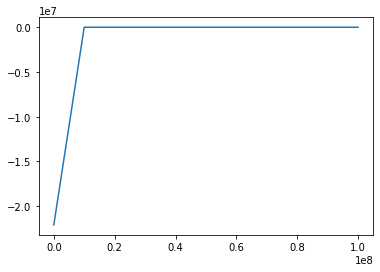

In [270]:
plt.plot(df_final.iloc[:,14],df_final.iloc[:,1])

In [272]:
plot(x='year', y=['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11','w12','w13'], figsize=(10,5), grid=True)
#plt.legned()
#plt.show()

NameError: name 'plot' is not defined

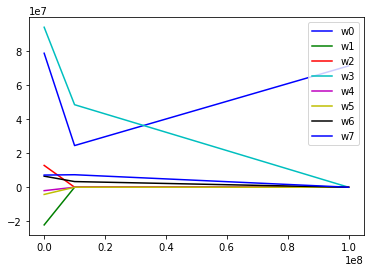

In [279]:

plt.plot(df_final.iloc[:,14],df_final.iloc[:,0] , 'b-', label='w0')
plt.plot(df_final.iloc[:,14],df_final.iloc[:,1] , 'g-', label='w1')

plt.plot(df_final.iloc[:,14],df_final.iloc[:,2] , 'r-', label='w2')
plt.plot(df_final.iloc[:,14],df_final.iloc[:,3] , 'c-', label='w3')


plt.plot(df_final.iloc[:,14],df_final.iloc[:,4] , 'm-', label='w4')
plt.plot(df_final.iloc[:,14],df_final.iloc[:,5] , 'y-', label='w5')

plt.plot(df_final.iloc[:,14],df_final.iloc[:,6] , 'k-', label='w6')
plt.plot(df_final.iloc[:,14],df_final.iloc[:,7] , 'b-', label='w7')


plt.legend()
plt.show()